# XGBoostによる住宅価格予測

## セットアップ&データセットについて

### GPUの使用状況を確認

In [1]:
!nvidia-smi

Mon Feb 26 00:23:02 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.236.01   Driver Version: 450.236.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:1F:00.0 Off |                    0 |
| N/A   43C    P0    38W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###  概要
- Kaggle "House Rent Prediction Dataset"
- https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset

#### 分析の目的
かつてマハラジャが住んでいた豪華な宮殿から，賑やかな大都市圏の高層住宅群，さらには人里離れた村の質素な小屋に至るまでインドの住宅事情は実に多様である。この豊かな多様性を持つインドの物件価格を予測してみよう。

カラムの概要 
- BHK；ベッドルーム・ホール・キッチンの数
- Rent：住宅・アパート・マンションの賃貸料金（目的変数）
- Size：住宅・アパート・マンションの面積（平方フィート）
- Floor：住宅・アパート・マンションがどの階にあるのか，何階分か（例：Ground out of 2->地上2階, 3 out of 5->5階建て3階など）
- Area Type：住宅・アパート・マンションの面積が計算される基準
- Area Locality：住宅・アパート・マンションの地域の名称
- City：住宅・アパート・マンションが位置する都市
- Furnishing Status：住宅・アパート・マンションの家具の状態
- Tenant Preferred：オーナー（または代理人）が好むその人の特性（独身/家族など）
- Bathroom：バスルームの数
- Point of Contact：詳細の問い合わせ先

### 場所
- 本ノートブックの「input」フォルダ＞「263」内に存在 ※263はデータID
- KAMONOHASHI上で作成したデータセットを読み込んだ場合、inputフォルダ内に配置されます

### 参考
- https://www.kaggle.com/code/iamsouravbanerjee/the-best-journeys-takes-you-home
- https://www.kaggle.com/code/josipvrdoljak/xgboost-beginners-guide-rent-prediction
- https://www.kaggle.com/code/anubhavgoyal10/house-rent-prediction-eda-10-models


## データセット読み込み
### csv読み込み

In [3]:
# import pandas as pd
import cudf as cd#cuDF(pandasに対応するライブラリ)
import cuml #cuML(scikit-learnに対応するライブラリ)
import datetime as dt
import xgboost as xgb
import numpy as np
import shap
import optuna
import matplotlib.pyplot as plt

In [4]:
file_path = '../input/training/286/House_Rent_Dataset (1).csv' #データセットの場所を指定して読み込み
# pdf = pd.read_csv(file_path) #pandas dataframe
cdf = cd.read_csv(file_path) #cudf dataframe

Q: データセットの先頭5行を表示させるには？

In [5]:
#コードを書いてみよう


Q: どうやって欠損値がないことを確認するか？

In [7]:
#コードを書いてみよう


欠損値がないことを確認。Posted Onは日付なので，datetime型に変換する

In [9]:
cdf['Posted On'] #このカラムを変換しよう

0       2022-05-18
1       2022-05-13
2       2022-05-16
3       2022-07-04
4       2022-05-09
           ...    
4741    2022-05-18
4742    2022-05-15
4743    2022-07-10
4744    2022-07-06
4745    2022-05-04
Name: Posted On, Length: 4746, dtype: object

In [10]:
#コードを書いてみよう


## 4. dataframeの変換

### 説明変数(x), 目的変数(y)に分割
- 目的変数：Rent
- 説明変数：Rent, Posted On以外の変数

Q: カラム（データフレームの変数名）の一覧を表示するには？

In [12]:
#コードを書いてみよう


Q1. Posted On以外を選択するには？ \
Q2. 目的変数(Rent)をドロップするには？ \
Q3. 目的変数のカラムを選択するには？

In [ ]:
#コードを書いてみよう


### 訓練データ・学習データに分割

In [199]:
#train_test_splitを用いてデータセットを分割
from cuml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cdf, y_cdf, train_size=0.7, random_state=42)

訓練データ

In [200]:
X_train.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 3322 entries, 3163 to 3312
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   BHK                3322 non-null   int64
 1   Size               3322 non-null   int64
 2   Floor              3322 non-null   object
 3   Area Type          3322 non-null   object
 4   Area Locality      3322 non-null   object
 5   City               3322 non-null   object
 6   Furnishing Status  3322 non-null   object
 7   Tenant Preferred   3322 non-null   object
 8   Bathroom           3322 non-null   int64
 9   Point of Contact   3322 non-null   object
dtypes: int64(3), object(7)
memory usage: 472.7+ KB


In [201]:
X_train.head()

,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
3163,2,960,1 out of 3,Super Area,Kovilambakkam,Chennai,Semi-Furnished,Family,2,Contact Owner
4653,3,10,1 out of 1,Carpet Area,"Ghatkesar, NH 2 2",Hyderabad,Furnished,Bachelors/Family,3,Contact Owner
81,1,500,1 out of 3,Carpet Area,"Rabindra Pally, Keshtopur",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
1540,2,800,2 out of 3,Super Area,Konanakunte,Bangalore,Semi-Furnished,Bachelors/Family,2,Contact Owner
3428,2,950,1 out of 2,Super Area,Madambakkam,Chennai,Semi-Furnished,Bachelors/Family,2,Contact Owner


In [202]:
y_train.head()

3163    11000
4653    15000
81       8200
1540    15000
3428    10500
Name: Rent, dtype: int64

テストデータ

In [203]:
X_test.head()

,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
2225,2,850,3 out of 4,Super Area,Padmanabha Nagar,Bangalore,Semi-Furnished,Bachelors/Family,2,Contact Owner
51,1,450,2 out of 2,Carpet Area,New Town,Kolkata,Unfurnished,Bachelors,1,Contact Owner
4550,4,100,1 out of 3,Super Area,Old Nallakunta,Hyderabad,Unfurnished,Bachelors/Family,2,Contact Owner
640,3,1080,5 out of 8,Carpet Area,Santacruz West,Mumbai,Unfurnished,Bachelors/Family,3,Contact Agent
3604,1,550,1 out of 2,Super Area,Pammal,Chennai,Unfurnished,Bachelors/Family,1,Contact Owner


In [204]:
y_test.head()

2225     18000
51        7500
4550     10000
640     100000
3604      9000
Name: Rent, dtype: int64

## 探索的データ分析

### プロット

ヒートマップで各変数の相関係数を確認する

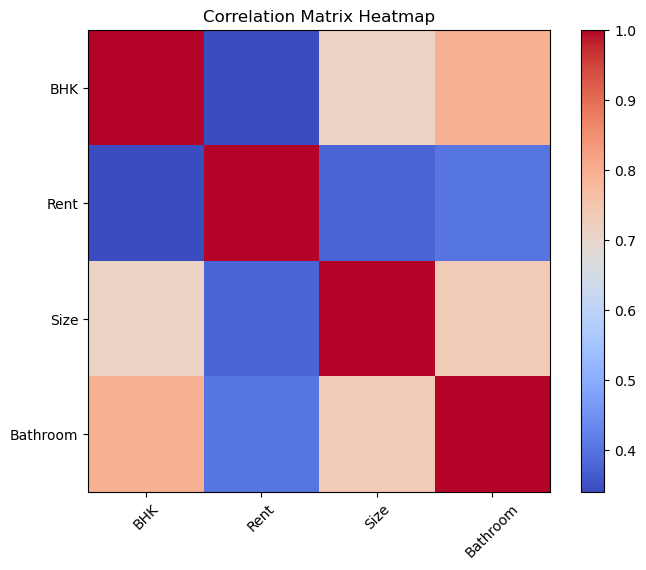

In [205]:
comb_df = cd.concat([X_train, y_train], axis=1)

corr = comb_df[['BHK', 'Rent', 'Size', 'Bathroom']].corr().to_pandas() #各列間の相関係数を計算し、pandas dataframeに変換

#ヒートマップを表示
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()  # カラーバーの追加
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix Heatmap')
plt.show()

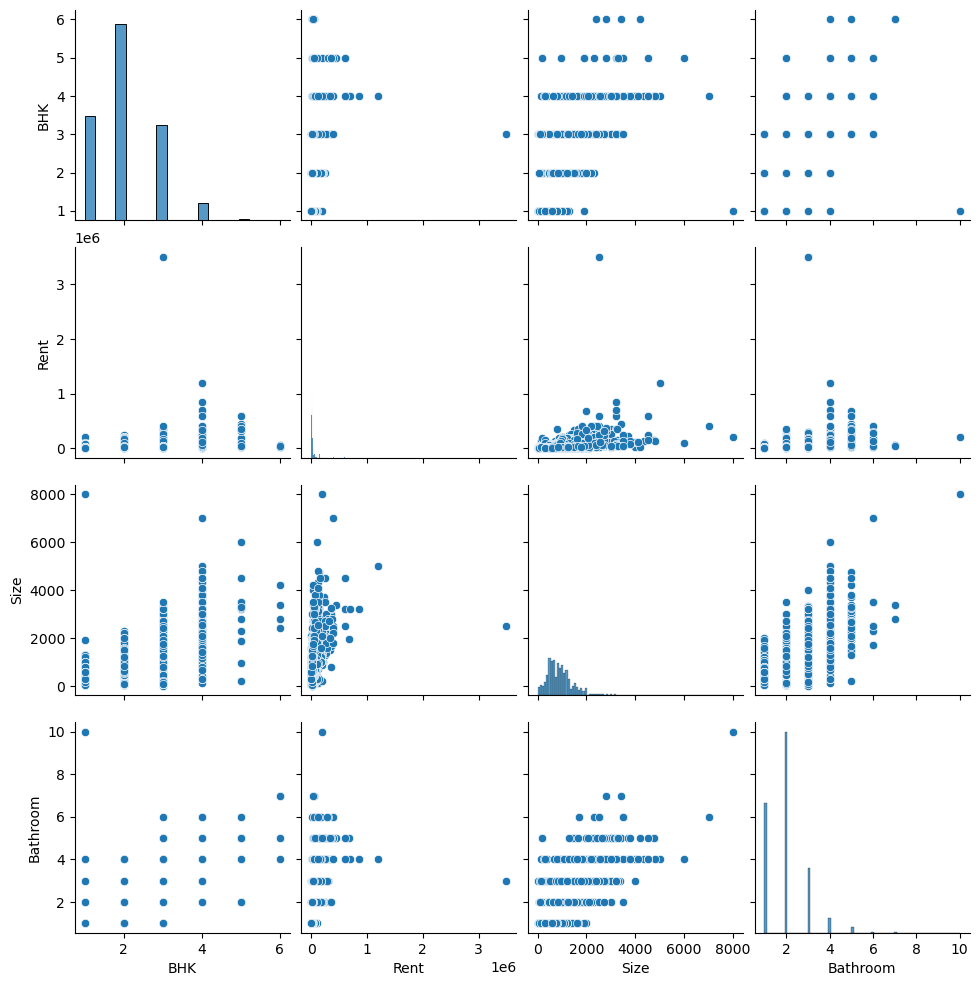

In [206]:
import seaborn as sns

#ペアプロットを表示
sns.pairplot(comb_df[['BHK', 'Rent', 'Size', 'Bathroom']].to_pandas())

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb84481e4c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb844829fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb844829850>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb844837580>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb844837850>],
 'means': []}

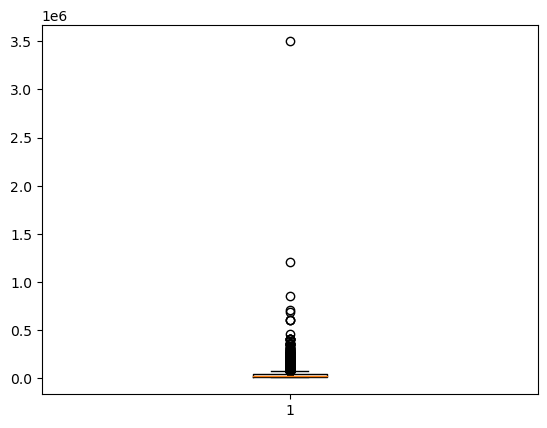

In [207]:
plt.boxplot(y_train) #箱ひげ図を表示

外れ値を除去する

In [208]:
# 目的変数のClipping
lower_bound = y_train.quantile(0.01)  # 下限値（1パーセンタイル）
upper_bound = y_train.quantile(0.99)  # 上限値（99パーセンタイル）
y_train = y_train.clip(lower_bound, upper_bound)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb8447d68b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb8447d6e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb8447d6700>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb8447e5430>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb8447e5700>],
 'means': []}

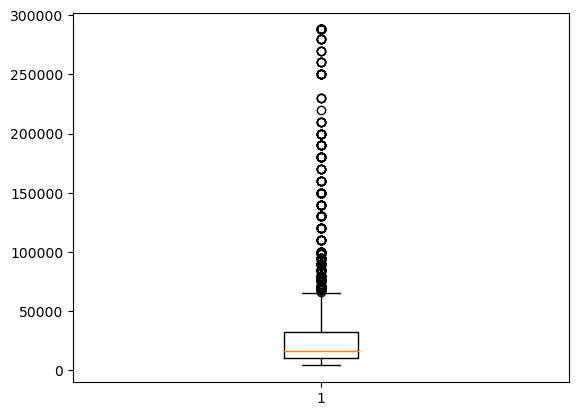

In [209]:
plt.boxplot(y_train) #箱ひげ図を表示

Q: そのほかに自分の好きなデータ可視化・必要だと思うデータの前処理をやってみよう

In [ ]:
# 書いてみよう

### ユニークな値を確認

In [210]:
X_train["City"].unique() #カラム内のユニークな値をカウント

0    Bangalore
1      Chennai
2        Delhi
3    Hyderabad
4      Kolkata
5       Mumbai
Name: City, dtype: object

In [211]:
X_train["City"].value_counts() #数をカウント

Mumbai       696
Bangalore    630
Chennai      622
Hyderabad    608
Delhi        400
Kolkata      366
Name: City, dtype: int32

In [212]:
X_train["Floor"].unique().head(10) #head()で先頭10行を表示

0              1
1     1 out of 1
2    1 out of 10
3    1 out of 12
4    1 out of 13
5    1 out of 14
6     1 out of 2
7    1 out of 20
8    1 out of 22
9    1 out of 24
Name: Floor, dtype: object

In [213]:
X_train["Floor"].unique().tail(10) #tail()で末尾10行を表示

389     Upper Basement out of 2
390    Upper Basement out of 20
391    Upper Basement out of 22
392     Upper Basement out of 3
393    Upper Basement out of 30
394     Upper Basement out of 4
395    Upper Basement out of 40
396     Upper Basement out of 5
397     Upper Basement out of 7
398     Upper Basement out of 9
Name: Floor, dtype: object

Floorに色々なカテゴリが存在，ダミー変数に変えるときにフロア階層を踏まえた変換をするのは時間がかかるので今回はカラムを落とす（dropする）

In [214]:
X_train["Area Locality"].value_counts()

Bandra West                       31
Miyapur, NH 9                     18
Electronic City                   17
Sholinganallur                    16
Chembur                           15
                                  ..
Hyderaguda-Attapur                 1
Sundew CHS, Chandivali             1
Opp. Deccan college, Darusalam     1
Yelahanka Dodda Ballapur Road      1
Bettadasanapura                    1
Name: Area Locality, Length: 1762, dtype: int32

Area Localityも同様の理由でdropする

Q: カラム"Floor"と"Area Locality"をドロップするには？

In [215]:
#コードを書いてみよう


In [217]:
X_train["Area Type"].value_counts()

Super Area     1696
Carpet Area    1624
Built Area        2
Name: Area Type, dtype: int32

In [218]:
X_train["City"].value_counts()

Mumbai       696
Bangalore    630
Chennai      622
Hyderabad    608
Delhi        400
Kolkata      366
Name: City, dtype: int32

In [219]:
X_train["Furnishing Status"].value_counts()

Semi-Furnished    1582
Unfurnished       1254
Furnished          486
Name: Furnishing Status, dtype: int32

In [220]:
X_train["Tenant Preferred"].value_counts()

Bachelors/Family    2400
Bachelors            573
Family               349
Name: Tenant Preferred, dtype: int32

In [221]:
X_train["Bathroom"].value_counts()

2     1600
1     1034
3      516
4      118
5       42
6        9
7        2
10       1
Name: Bathroom, dtype: int32

In [222]:
X_train["Point of Contact"].value_counts()

Contact Owner      2243
Contact Agent      1078
Contact Builder       1
Name: Point of Contact, dtype: int32

### 特徴量変換

Q: カテゴリ変数を1-hotベクトル(ダミー変数)に変更するには？

In [223]:
# 書いてみよう


確認

In [225]:
X_train.head()

,BHK,Size,Bathroom,Area Type_Built Area,Area Type_Carpet Area,Area Type_Super Area,City_Bangalore,City_Chennai,City_Delhi,City_Hyderabad,...,City_Mumbai,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Tenant Preferred_Bachelors,Tenant Preferred_Bachelors/Family,Tenant Preferred_Family,Point of Contact_Contact Agent,Point of Contact_Contact Builder,Point of Contact_Contact Owner
3163,2,960,2,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4653,3,10,3,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,1
81,1,500,1,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
1540,2,800,2,0,0,1,1,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3428,2,950,2,0,0,1,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


### XGBoost用の型に変換

In [226]:
X_train.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 3322 entries, 3163 to 3312
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   BHK                                3322 non-null   int64
 1   Size                               3322 non-null   int64
 2   Bathroom                           3322 non-null   int64
 3   Area Type_Built Area               3322 non-null   uint8
 4   Area Type_Carpet Area              3322 non-null   uint8
 5   Area Type_Super Area               3322 non-null   uint8
 6   City_Bangalore                     3322 non-null   uint8
 7   City_Chennai                       3322 non-null   uint8
 8   City_Delhi                         3322 non-null   uint8
 9   City_Hyderabad                     3322 non-null   uint8
 10  City_Kolkata                       3322 non-null   uint8
 11  City_Mumbai                        3322 non-null   uint8
 12  Furnishing Stat

In [227]:
X_test.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 1424 entries, 2225 to 2822
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   BHK                                1424 non-null   int64
 1   Size                               1424 non-null   int64
 2   Bathroom                           1424 non-null   int64
 3   Area Type_Carpet Area              1424 non-null   uint8
 4   Area Type_Super Area               1424 non-null   uint8
 5   City_Bangalore                     1424 non-null   uint8
 6   City_Chennai                       1424 non-null   uint8
 7   City_Delhi                         1424 non-null   uint8
 8   City_Hyderabad                     1424 non-null   uint8
 9   City_Kolkata                       1424 non-null   uint8
 10  City_Mumbai                        1424 non-null   uint8
 11  Furnishing Status_Furnished        1424 non-null   uint8
 12  Furnishing Stat

trainとtestで異なるカラムの確認

In [231]:
X_train['Point of Contact_Contact Builder'].sum()

1

In [233]:
X_train['Area Type_Built Area'].sum()

2

どちらもデータ数の少ないカラムなので削除する

In [234]:
X_train.drop(['Point of Contact_Contact Builder','Area Type_Built Area'], axis=1, inplace=True)

In [235]:
#DMatrixに変換
dtrain = xgb.DMatrix(X_train, y_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## XGBoostの学習，評価

In [167]:
from cuml.ensemble import RandomForestClassifier
import cuml
from cuml.metrics import mean_squared_error
from cuml.metrics.accuracy import accuracy_score
import time
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from numpy import interp
import pickle

### Optunaによるチューニングとモデル構築

In [168]:
#Optuna
def objective(trial):
    # ハイパーパラメータの範囲を設定
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'max_leaves': trial.suggest_int('max_leaves', 100, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': #####,
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0),
        'tree_method': 'gpu_hist',
        'grow_policy': 'lossguide'
    }
    # 学習
    cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5, metrics={'rmse'}, seed=2024)
    # cv結果の平均値をreturnに使用
    rmse = cv_results['test-rmse-mean'].mean()

    return rmse

Q: 上の「#####」となっているところについて次のうちどれがあてはまる？

- trial.suggest_float('reg_alpha', 1e-5, 1.0) 
- trial.suggest_int('reg_alpha', 1e-5, 1) 
- trial.suggest_float('reg_alpha', -1.0, 1.0) 

ヒント1：`reg_alpha`がXGBoostモデルの何のパラメーターなのか調べてみよう \
ヒント2；`float`は浮動小数点型，`int`は整数型をさす

In [238]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-26 00:36:04,602] A new study created in memory with name: no-name-c0bdd5c4-3d22-49a8-9894-b9276c1b683f
[I 2024-02-26 00:36:05,030] Trial 0 finished with value: 28061.612422855647 and parameters: {'max_depth': 4, 'max_leaves': 162, 'learning_rate': 0.9788758566452918, 'n_estimators': 481, 'min_child_weight': 2, 'subsample': 0.5990870880342882, 'colsample_bytree': 0.5031435945608533, 'reg_alpha': 0.5728650703270779, 'reg_lambda': 0.9241910073124755}. Best is trial 0 with value: 28061.612422855647.
[I 2024-02-26 00:36:05,557] Trial 1 finished with value: 23079.43555548744 and parameters: {'max_depth': 7, 'max_leaves': 166, 'learning_rate': 0.9998210136887913, 'n_estimators': 634, 'min_child_weight': 2, 'subsample': 0.9245216736251411, 'colsample_bytree': 0.9581880736196671, 'reg_alpha': 0.9730110010347018, 'reg_lambda': 0.7188858133062331}. Best is trial 1 with value: 23079.43555548744.
[I 2024-02-26 00:36:05,944] Trial 2 finished with value: 23288.034515902153 and parameters: 

Number of finished trials: 100
Best trial: {'max_depth': 5, 'max_leaves': 185, 'learning_rate': 0.738282730515829, 'n_estimators': 259, 'min_child_weight': 7, 'subsample': 0.9885731814820549, 'colsample_bytree': 0.9825823655489213, 'reg_alpha': 0.9385558965961582, 'reg_lambda': 0.4251643661052795}


### チューニング後のパラメータで学習と予測

In [239]:
#学習
model = xgb.train(study.best_params, dtrain)
#テスト（評価）データの予測値（カテゴリ変数）を取得
pred = model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test.to_numpy(), pred))

In [240]:
rmse

array(37371.24254838)

### SHAPによる解釈

In [241]:
shap.initjs() #Jupyter Lab 上でグラフを表示するためのおまじない

In [242]:
#SHAP値を計算
explainer = shap.TreeExplainer(model=xgb.train(study.best_trial.params, dtrain), feature_perturbation='tree_path_dependent', model_output='raw')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

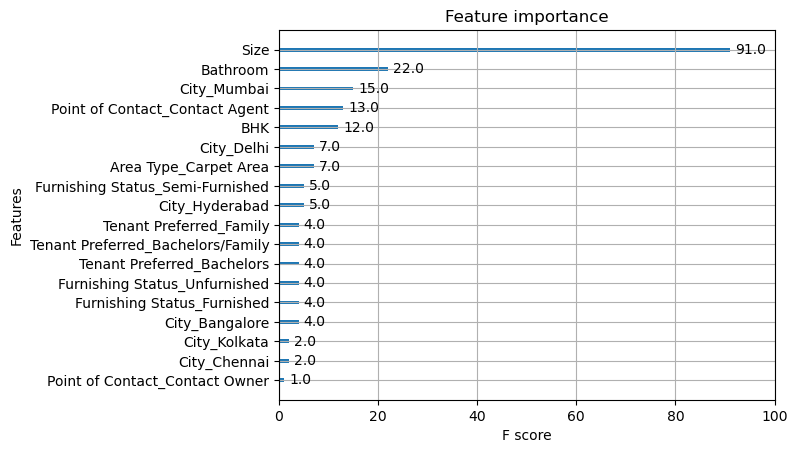

In [243]:
#まずはXGBoostの機能で特徴量の重要度を表示
xgb.plot_importance(xgb.train(study.best_trial.params, dtrain))

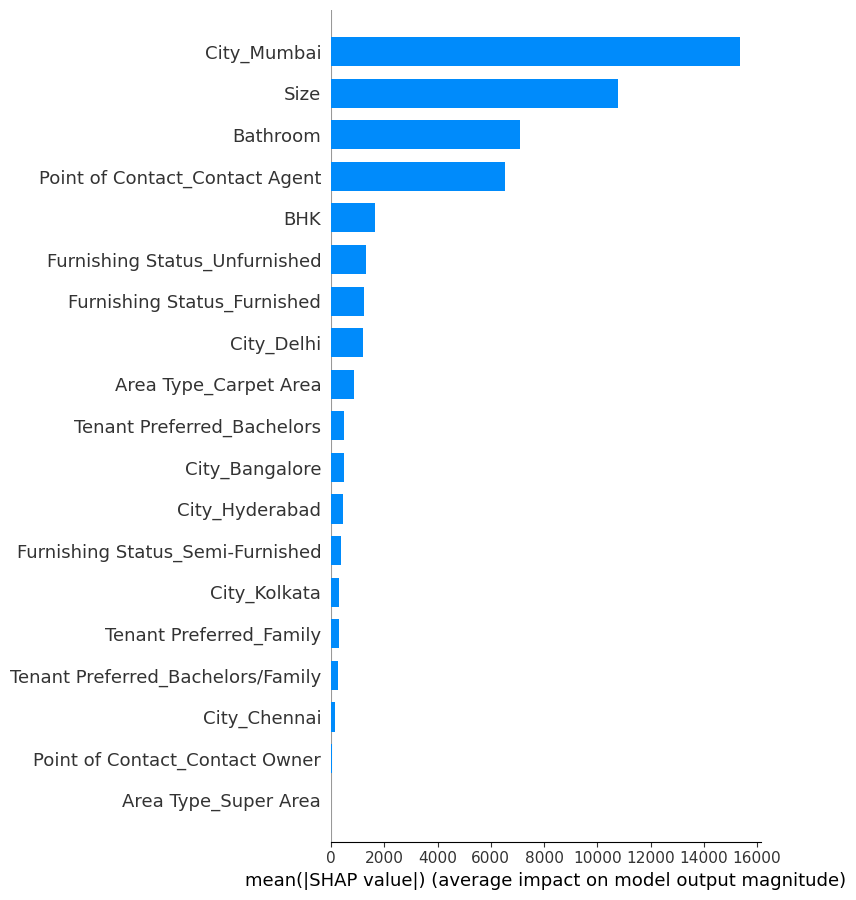

In [244]:
#次にSHAP値のグラフを表示
shap_values = explainer.shap_values(X=X_train)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_train.columns)

### 決定木を可視化

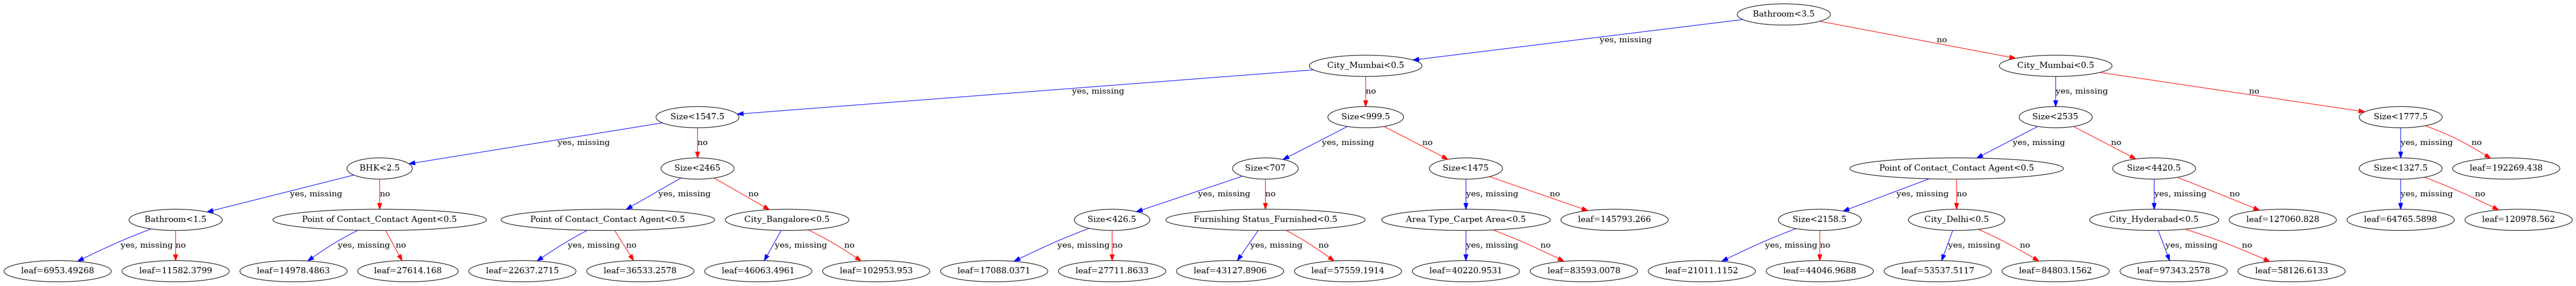

In [245]:
from graphviz import Source
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 200,200

xgb.plot_tree(xgb.train(study.best_trial.params, dtrain), fontsize=10)
plt.show()